#IMPORTS

In [1]:
import csv
import numpy as np
import pandas as pd
import os
import re
import collections

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


#HELPER FUNCTIONS

In [23]:
'''
Plot a Confusion Matrix
'''
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm) 
    # plt.title('Confusion Matrix \n where k is {} \n'.format(k)) 
    fig.colorbar(cax) 
    plt.xlabel('Predicted') 
    plt.ylabel('True') 
    plt.show()
  
  
'''
If a session belongs to the LAB or not.
'''
def is_lab(session):
    bol = []
    for i in session:
        foo = i.split('_')
        idd = int(foo[1])
        if idd<5:
            bol.append(True)
        else:
            bol.append(False)
    bol = np.array(bol)
    return pd.Series(bol)


'''
If a session belongs to the DAILY or not.
'''
def is_daily(session):
    bol = []
    for i in session:
        foo = i.split('_')
        idd = int(foo[1])
        if idd<5:
            bol.append(False)
        else:
            bol.append(True)
    bol = np.array(bol)
    return pd.Series(bol)

'''
Does a majority vote among the predicted results. Adds the majority prediction to a new column
and returns this dataframe
'''
def do_majority_vote(X_test, y_pred):
    # Put predicted results in a new column
    X_test['Predicted'] = np.array(y_pred)

    all_sessions = X_test["Session"].unique()
    # For each session
    for session in all_sessions:
        low = len(X_test[(X_test.Session == session) & (X_test.Predicted == 'L')])  # Number of low stress predicted frames
        medium = len(X_test[(X_test.Session == session) & (X_test.Predicted == 'M')])  # Number of medium stress predicted frames
        high = len(X_test[(X_test.Session == session) & (X_test.Predicted == 'H')])  # Number of high stress predicted frames
        # Do majority vote
        # Assign the majority prediction of this session to Predicted_Aggregated of each frame in the session
        if low >= high and low >= medium:
            X_test.loc[X_test['Session'] == session, 'Prediction_with_majority'] = 'L'
        elif high >= medium and high >= low:
            X_test.loc[X_test['Session'] == session, 'Prediction_with_majority'] = 'H'
        else:
            # In case low = medium = high, it makes sense to assign Predicted_Aggregated to M
            X_test.loc[X_test['Session'] == session, 'Prediction_with_majority'] = 'M'
    return X_test['Prediction_with_majority']

#DATA LOADING GUIDE

In [17]:
################################################################################ 
########################## DATA LOADING GUIDE ##################################
################################################################################
'''
LOAD ALL DATA AND SPLIT INTO TRAIN AND TEST
'''
# X = data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
# y = data['TwoClassWithKnown']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

'''
LOAD DAILY DATA AND SPLIT INTO TRAIN AND TEST
'''
# X = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
# y = daily_data['TwoClassWithKnown']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
# X = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
# y = lab_data['TwoClassWithKnown']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


'''
LOAD LAB DATA TO TRAIN & DAILY DATA TO TEST
'''
# X_train = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
# y_train = lab_data['TwoClassLabel']
# X_test = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
# y_test = daily_data['TwoClassLabel']

'\nLOAD LAB DATA TO TRAIN & DAILY DATA TO TEST\n'

#LOAD SCORING HELPER

In [3]:
scoring = pd.read_csv('https://raw.githubusercontent.com/abcdrk/stress-detection/master/scoring_helper.csv')
scoring.head()

,Session,DeviceID,ParticipantID,UTC_Start,UTC_End,2ClassScore,3ClassScore,KnownContext
0,1,A012B4,1,1552980542,1552991342,L,M,L
1,2,A010C3,1,1552990800,1552991100,L,M,H
2,3,A010C3,1,1552991491,1552992391,H,H,M
3,4,A010C3,1,1552992660,1552992960,L,L,A
4,5,A010C3,1,1552993140,1552993440,L,M,NaN




---



---

# LOAD LABEL.CSV (ALL DATA)

---


---



We are loading the data from the .csv *file*

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/abcdrk/stress-detection/master/labels_sessions.csv')
# lab_data = data[data.SessionID == "A010C3"]
# daily_data = data[data.SessionID != "A010C3"]


'''
UNCOMMENT RELATED PLACE TO EXAMINE THE DATA
'''
# DISPLAY ALL
# pd.set_option('display.max_rows', 1000)
# data

# SEE THE DATA COLUMS
# print(data.columns)

# DROP WHERE KNOWNLABEL == NaN
# foo = data.dropna()
# ERROR: SOME DEVICE CODES AND SESSION_ID'S DOESN'T MATCH
# foo[foo.SessionID != foo.Device]


'''
UNCOMMENT TO SEE THE IMBALANCE BETWEEN STRESS CLASSES
'''
# low = data[data.ThreeClassLabel == "L"]
# print("LOW labeled: ", len(low))
# med = data[data.ThreeClassLabel == "M"]
# print("MEDIUM labeled: ", len(med))
# high = data[data.ThreeClassLabel == "H"]
# print("HIGH labeled: ", len(high))
# print("------------------------")
# print("LAB DATA: ", len(lab_data))
# print("DAILY DATA: ", len(daily_data))

'\nUNCOMMENT TO SEE THE IMBALANCE BETWEEN STRESS CLASSES\n'

In [5]:
import sqlite3

conn = sqlite3.connect(':memory:')
data.to_sql('data_df', conn, index=False)
scoring.to_sql('scoring_df', conn, index=False)

qry = '''
    select
        *
    from
        data_df
    join
        scoring_df
    on
        (scoring_df.UTC_Start <= data_df.Start_time) and (scoring_df.UTC_end >= data_df.endTime) and (scoring_df.DeviceID == data_df.Device)
    '''

all_data = pd.read_sql_query(qry, conn)

lab_data = all_data[data.SessionID == "A010C3"]
daily_data = all_data[data.SessionID != "A010C3"]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


#Train in LAB Test in DAILY

##2 CLASSES: LOW - HIGH STRESS

In [68]:
'''
LOAD LAB DATA TO TRAIN & DAILY DATA TO TEST
'''
X_train = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
y_train = lab_data['TwoClassLabel']
X_test = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']]
y_test = daily_data['TwoClassLabel']


'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)


'''
To see that classes are balanced back
'''
# low = y_train[y_train == "L"]
# print("LOW labeled: ", len(low))
# high = y_train[y_train == "H"]
# print("HIGH labeled: ", len(high))

'\nTo see that classes are balanced back\n'

### Logistic Regression

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Logistic Regression score:  0.5757290767903365


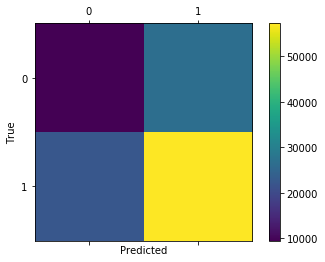

In [24]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Logistic Regression score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

### Naive Bayes

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Naive Bayes score:  0.3668421052631579


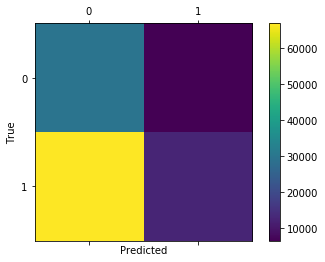

In [25]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Naive Bayes score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Decision Tree

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Decision Tree score:  0.6830284728213978


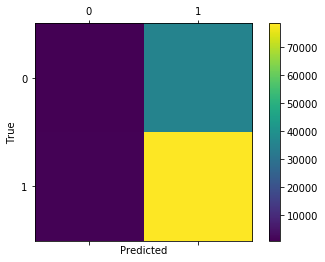

In [26]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Decision Tree score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Linear Discriminant Analysis (LDA)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


LDA score:  0.5504055220017257


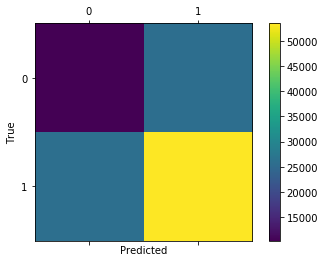

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('LDA score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###K-Neigbours Classifier

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


K-Neighbours score:  0.6792666091458154


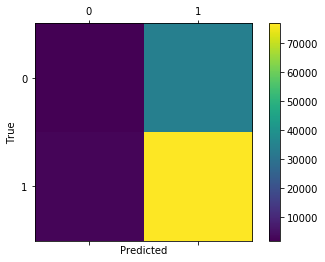

In [28]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('K-Neighbours score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###SVM

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


SVM score:  0.5743313201035375


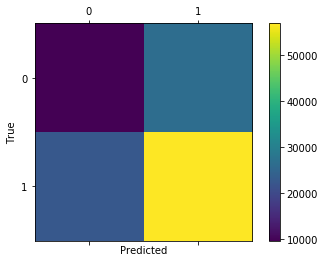

In [29]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('SVM score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

##3 CLASSES: LOW - MEDIUM - HIGH STRESS

In [32]:
'''
LAB DATA TO TRAIN & DAILY DATA TO TEST
'''
X_train = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
y_train = lab_data['ThreeClassLabel']
X_test = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']]
y_test = daily_data['ThreeClassLabel']

'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

Logistic Regression score:  0.3096635030198447


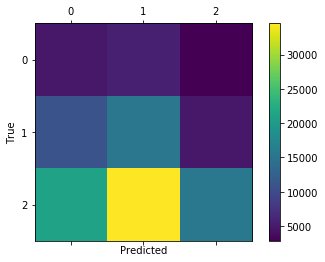

In [33]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Logistic Regression score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

### Naive Bayes

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Naive Bayes score:  0.2617946505608283


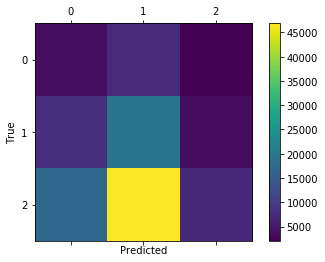

In [35]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Naive Bayes score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Decision Tree

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Decision Tree score:  0.43270923209663503


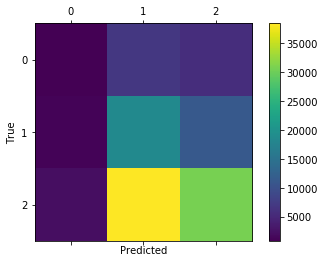

In [36]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Decision Tree score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Linear Discriminant Analysis (LDA)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


LDA score:  0.29166522864538397


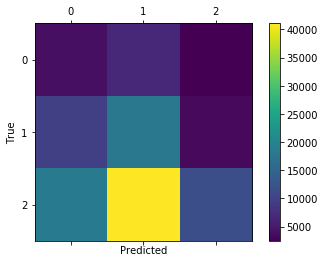

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('LDA score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###K-Neigbours Classifier

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


K-Neighbours score:  0.39499568593615186


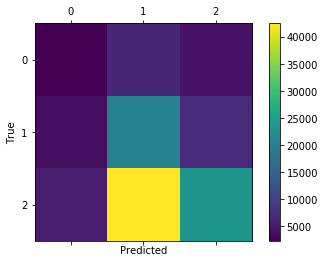

In [38]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('K-Neighbours score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###SVM

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


SVM score:  0.3146160483175151


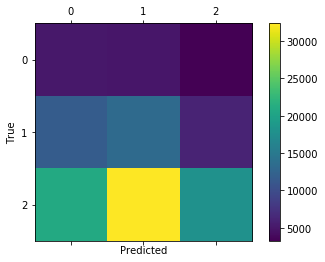

In [39]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('SVM score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

#Train and Test in LAB

##2 CLASSES: LOW - HIGH STRESS

In [82]:
'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
X = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak','Session']]
y = lab_data['TwoClassWithKnown']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Since train_test_split returns list of lists convert them to Dataframes
X_train = pd.DataFrame(X_train)
X_train.columns = ['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']
X_train = X_train.drop(columns=['Session'])

X_test = pd.DataFrame(X_test)
X_test.columns = ['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']


'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)


'''
To see that classes are balanced back
'''
# low = y_train[y_train == "L"]
# print("LOW labeled: ", len(low))
# high = y_train[y_train == "H"]
# print("HIGH labeled: ", len(high))

'\nTo see that classes are balanced back\n'

### Logistic Regression






Logistic Regression score:  0.8260869565217391


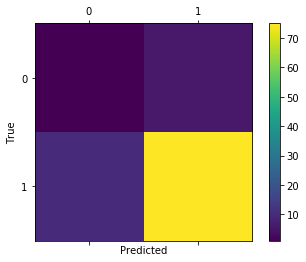

In [83]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Logistic Regression score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

### Naive Bayes

Naive Bayes score:  0.16304347826086957


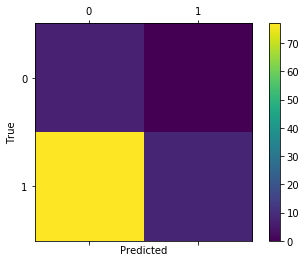

In [84]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Naive Bayes score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Decision Tree

Decision Tree score:  0.9565217391304348


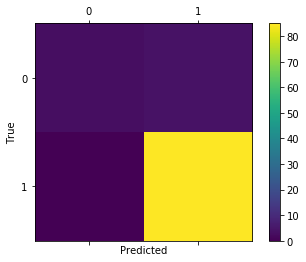

In [85]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Decision Tree score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Linear Discriminant Analysis (LDA)

LDA score:  0.8043478260869565


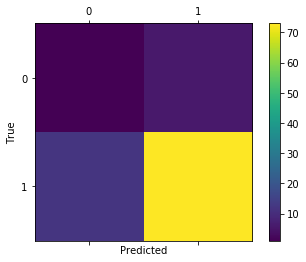

In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('LDA score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###K-Neigbours Classifier

K-Neighbours score:  1.0


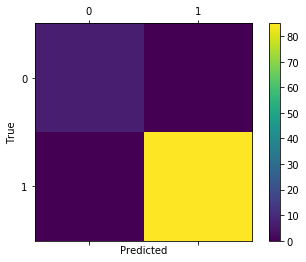

In [87]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('K-Neighbours score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###SVM

SVM score:  0.8260869565217391


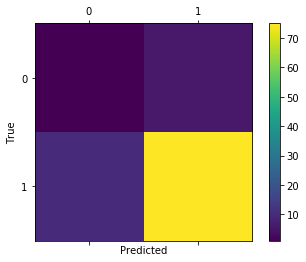

In [88]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('SVM score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

##3 CLASSES: LOW - MEDIUM - HIGH STRESS

In [0]:
'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
X = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
y = lab_data['ThreeClassWithKnown']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

Logistic Regression score:  0.5760869565217391


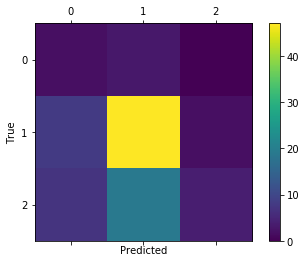

In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Logistic Regression score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

### Naive Bayes

Naive Bayes score:  0.16304347826086957


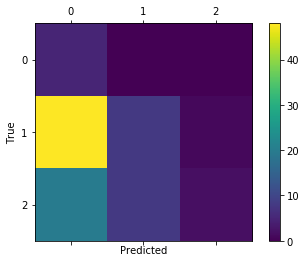

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Naive Bayes score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Decision Tree

Decision Tree score:  0.6739130434782609


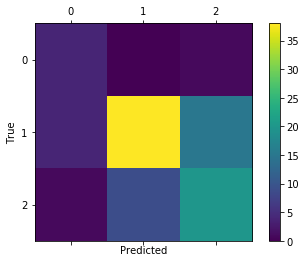

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Decision Tree score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) score:  0.5760869565217391


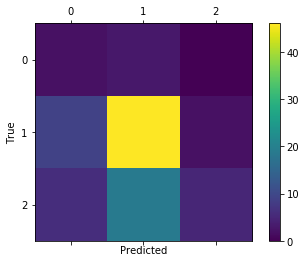

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('LDA score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###K-Neigbours Classifier

['H' 'M' 'H' 'H' 'L' 'L' 'L' 'L' 'L' 'M' 'L' 'L' 'M' 'L' 'L' 'L' 'L' 'L'
 'L' 'M' 'L' 'M' 'L' 'M' 'L' 'M' 'H' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'M' 'L'
 'L' 'M' 'H' 'L' 'M' 'M' 'L' 'M' 'L' 'L' 'L' 'M' 'L' 'L' 'L' 'M' 'L' 'H'
 'L' 'M' 'H' 'M' 'L' 'L' 'M' 'L' 'L' 'H' 'L' 'L' 'M' 'L' 'L' 'L' 'M' 'L'
 'L' 'L' 'M' 'H' 'L' 'H' 'L' 'L' 'L' 'M' 'L' 'H' 'H' 'L' 'H' 'L' 'L' 'H'
 'L' 'L']
K-Neighbours score: 0.6956521739130435


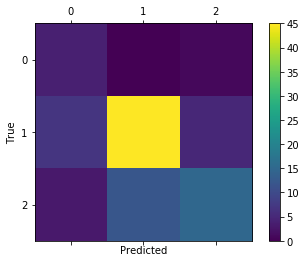

In [0]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('K-Neighbours score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###SVM

['L' 'L' 'H' 'H' 'L' 'L' 'M' 'L' 'L' 'M' 'L' 'L' 'H' 'L' 'L' 'L' 'L' 'L'
 'L' 'L' 'L' 'L' 'L' 'H' 'L' 'L' 'L' 'L' 'H' 'H' 'H' 'H' 'H' 'L' 'H' 'L'
 'L' 'L' 'L' 'L' 'M' 'L' 'L' 'L' 'L' 'L' 'L' 'H' 'L' 'L' 'L' 'L' 'L' 'L'
 'H' 'H' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'H' 'L' 'L' 'L' 'H' 'L' 'L' 'L'
 'L' 'H' 'M' 'L' 'L' 'L' 'L' 'L' 'L' 'M' 'L' 'L' 'H' 'L' 'H' 'L' 'L' 'L'
 'L' 'L']
SVM score: 0.5760869565217391


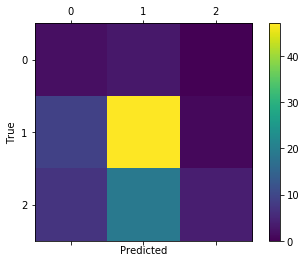

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('SVM score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

#Train and Test in DAILY

##2 CLASSES: LOW - HIGH STRESS

In [90]:
'''
LOAD DAILY DATA AND SPLIT INTO TRAIN AND TEST
'''
X = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']]
y = daily_data['TwoClassWithKnown']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Since train_test_split returns list of lists convert them to Dataframes
X_train = pd.DataFrame(X_train)
X_train.columns = ['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']
X_train = X_train.drop(columns=['Session'])

X_test = pd.DataFrame(X_test)
X_test.columns = ['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']

'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)


'''
To see that classes are balanced back
'''
# low = y_train[y_train == "L"]
# print("LOW labeled: ", len(low))
# high = y_train[y_train == "H"]
# print("HIGH labeled: ", len(high))

'\nTo see that classes are balanced back\n'

### Logistic Regression






Logistic Regression score:  0.6515530629853322


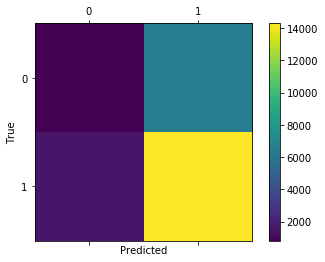

In [91]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Logistic Regression score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

### Naive Bayes

Naive Bayes score:  0.6786885245901639


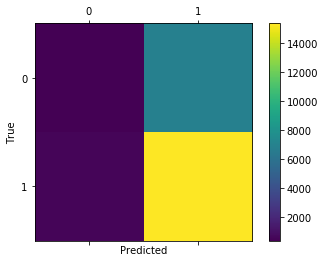

In [92]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Naive Bayes score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Decision Tree

Decision Tree score:  0.6820103537532356


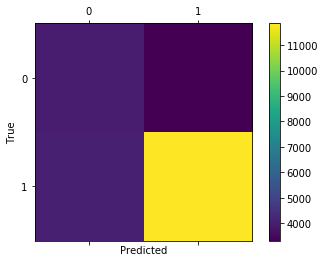

In [93]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Decision Tree score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Linear Discriminant Analysis (LDA)

LDA score:  0.640207075064711


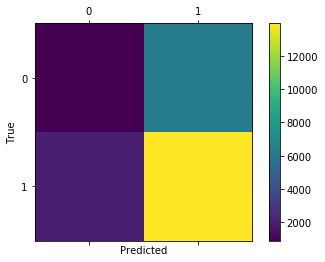

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('LDA score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###K-Neigbours Classifier

K-Neighbours score:  0.5606988783433995


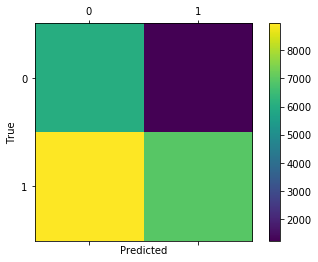

In [95]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])
predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('K-Neighbours score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###SVM

SVM score:  0.6515530629853322


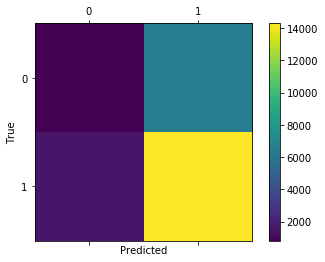

In [96]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])
predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('SVM score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

##3 CLASSES: LOW - MEDIUM - HIGH STRESS

In [97]:
'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
X = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']]
y = daily_data['ThreeClassWithKnown']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Since train_test_split returns list of lists convert them to Dataframes
X_train = pd.DataFrame(X_train)
X_train.columns = ['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']
X_train = X_train.drop(columns=['Session'])

X_test = pd.DataFrame(X_test)
X_test.columns = ['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'Session']

'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

Logistic Regression score:  0.5643658326143227


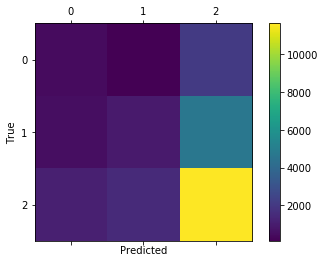

In [98]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Logistic Regression score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

### Naive Bayes

Naive Bayes score:  0.6090595340811044


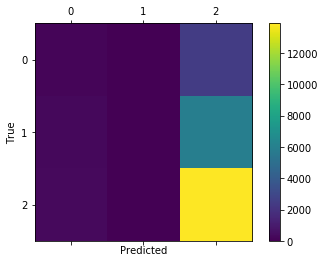

In [99]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Naive Bayes score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Decision Tree

Decision Tree score:  0.6233390854184642


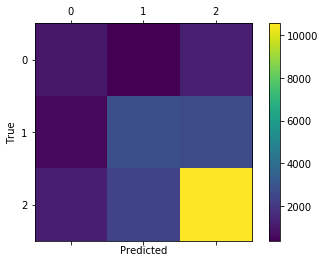

In [100]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('Decision Tree score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###Linear Discriminant Analysis (LDA)

LDA score:  0.566695427092321


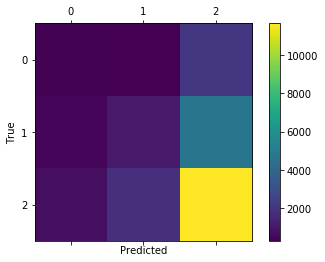

In [101]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('LDA score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###K-Neigbours Classifier

K-Neighbours score:  0.5425366695427092


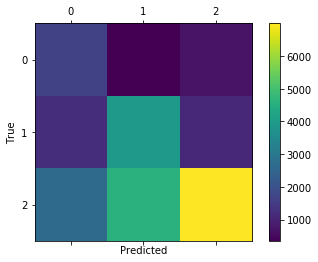

In [102]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('K-Neighbours score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

###SVM

SVM score:  0.573123382226057


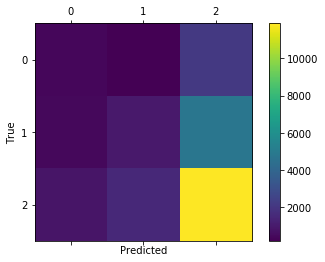

In [103]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']])

predictions_with_majority = do_majority_vote(X_test, y_pred)

accuracy = sum(1 for x,y in zip(y_test, predictions_with_majority) if x == y) / len(y_test)
print('SVM score: ', accuracy)
conf_matrix(y_test, predictions_with_majority)

#Leave One Person Out (LAB and DAILY Mixed)



---



---


#LOAD AVAREGED DATA

---


---



In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/abcdrk/stress-detection/master/492_label_avg_known.csv')
lab_data = data[is_lab(data.SessionID)]
daily_data = data[is_daily(data.SessionID)]

'''
UNCOMMENT RELATED PLACE TO EXAMINE THE DATA
'''
# DISPLAY ALL
# pd.set_option('display.max_rows', 1000)
# data

# SEE THE DATA COLUMS
# print(data.columns)


# DROP WHERE KNOWNLABEL == NaN
# foo = data.dropna()
# ERROR: SOME DEVICE CODES AND SESSION_ID'S DOESN'T MATCH
# foo[foo.SessionID != foo.Device]
daily_data

,SessionID,Mean,Peak,Perc20,Perc80,QuartDev,Std,Strong_Peak,dataQual,Max,Min,TwoClassLabel,ThreeClassLabel,IsLab
9,11_10,3.031553,6.452499,1.992207,4.066126,1.680668,1.182239,0.564250,0.092943,5.319181,0.747569,1,1,N
10,11_11,3.791633,5.967466,2.912305,4.628918,1.368068,0.971453,0.921804,0.036316,5.984032,2.043227,1,1,N
11,11_12,0.390993,3.984205,-0.118267,0.896433,0.818810,0.568439,0.149782,0.166258,1.462000,-0.710638,1,2,N
12,11_13,0.560042,2.894093,0.269842,0.868535,0.480231,0.361421,0.284048,0.105530,1.093218,-0.241805,3,2,N
13,11_14,0.303364,2.932867,-0.250511,0.859584,0.911172,0.609929,0.150337,0.119946,1.219869,-0.947128,3,2,N
14,11_15,1.335406,2.994444,0.782374,1.889962,0.895539,0.629226,0.151852,0.073611,2.335075,0.106783,3,3,N
15,11_16,0.292748,3.876081,-0.524395,1.134062,1.361375,0.958684,0.100865,0.281820,1.610501,-1.758359,3,2,N
16,11_17,0.937325,5.108089,0.693823,1.226246,0.420473,0.358828,0.034868,0.067381,1.444576,0.085933,1,2,N
17,11_18,0.447700,3.161111,0.091025,0.813746,0.567809,0.439320,0.051111,0.088611,1.040521,-0.530017,1,1,N
18,11_19,0.373120,2.464503,0.201778,0.571864,0.294277,0.247331,0.033807,0.067613,0.691976,-0.216150,1,1,N


#Train in LAB Test in DAILY

##2 CLASSES: LOW - HIGH STRESS

In [0]:
'''
LOAD LAB DATA TO TRAIN & DAILY DATA TO TEST
'''
X_train = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
y_train = lab_data['TwoClassLabel']
X_test = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
y_test = daily_data['TwoClassLabel']


'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)


'''
To see that classes are balanced back
'''
# low = y_train[y_train == "L"]
# print("LOW labeled: ", len(low))
# high = y_train[y_train == "H"]
# print("HIGH labeled: ", len(high))

'\nTo see that classes are balanced back\n'

### Logistic Regression






Logistic Regression score:  0.5873015873015873


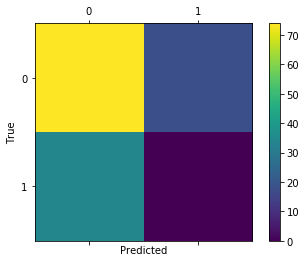

In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Logistic Regression score: ",clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

### Naive Bayes

Naive Bayes score:  0.29365079365079366


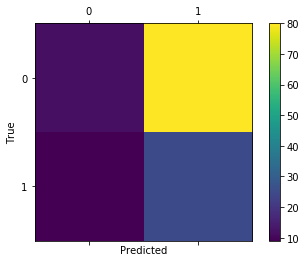

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test)
gnb.score(X_test, y_test)

print("Naive Bayes score: ", gnb.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Decision Tree

Decision Tree score:  0.6666666666666666


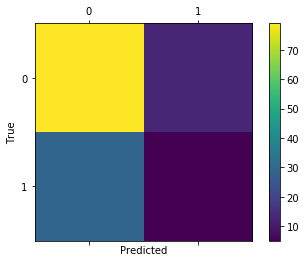

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)

print("Decision Tree score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) score:  0.5396825396825397


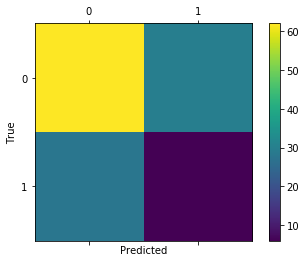

In [0]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Linear Discriminant Analysis (LDA) score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###K-Neigbours Classifier

[1 1 3 1 1 1 3 3 1 1 1 1 1 3 3 1 1 1 3 1 1 1 1 1 1 3 1 1 3 1 3 1 3 3 1 1 1
 1 3 1 1 3 3 3 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1
 1 1 1 1 3 1 1 3 3 1 1 1 1 3 1 3 1 3 1 3 1 1 1 3 1 1 1 3 1 1 1 1 1 1 1 1 1
 3 3 3 3 1 1 3 3 3 3 3 3 1 1 1]
K-Neighbours score: 0.6190476190476191


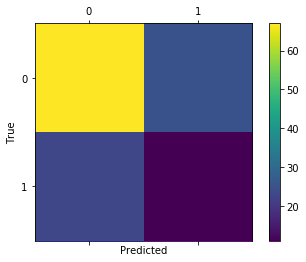

In [0]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(y_pred)
print("K-Neighbours score:", neigh.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###SVM

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 3 3 3 1 1
 1 1 1 1 3 1 1 1 3 1 1 1 3 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1]
SVM score: 0.6587301587301587


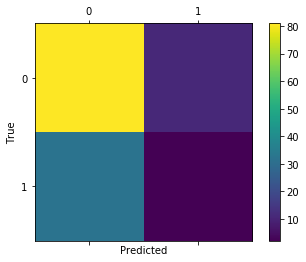

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
print("SVM score:", model.score(X_test, y_test))
conf_matrix(y_test, y_pred)

##3 CLASSES: LOW - MEDIUM - HIGH STRESS

In [0]:
'''
LAB DATA TO TRAIN & DAILY DATA TO TEST
'''
X_train = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
y_train = lab_data['ThreeClassLabel']
X_test = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak']]
y_test = daily_data['ThreeClassLabel']

'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

Logistic Regression score:  0.5476190476190477


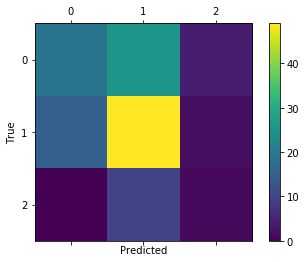

In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Logistic Regression score: ",clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

### Naive Bayes

Naive Bayes score:  0.30952380952380953


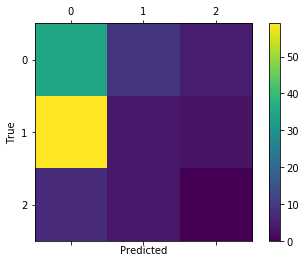

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test)
gnb.score(X_test, y_test)

print("Naive Bayes score: ", gnb.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Decision Tree

Decision Tree score:  0.36507936507936506


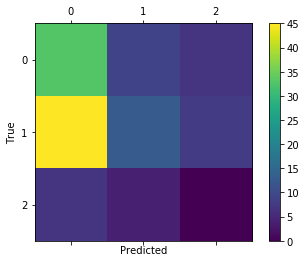

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)

print("Decision Tree score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) score:  0.3333333333333333


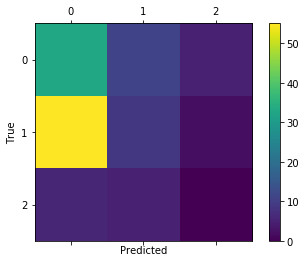

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Linear Discriminant Analysis (LDA) score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###K-Neigbours Classifier

[1 1 3 2 3 2 3 3 2 1 1 1 2 3 3 2 1 1 2 1 1 1 1 1 2 2 2 3 3 2 3 2 3 3 1 3 1
 1 2 1 2 3 2 3 3 1 1 1 1 1 3 1 3 1 1 1 1 3 3 3 3 3 1 1 1 1 2 3 1 3 2 2 1 3
 3 1 1 3 2 3 2 2 1 1 3 1 2 3 2 3 1 1 3 3 1 3 1 3 2 1 2 3 1 1 3 3 3 3 1 2 1
 1 1 2 1 1 1 2 3 3 1 3 3 3 3 1]
K-Neighbours score: 0.2777777777777778


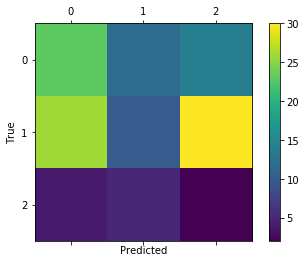

In [0]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(y_pred)
print("K-Neighbours score:", neigh.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###SVM

[2 2 2 1 2 2 2 1 2 1 2 2 2 2 2 3 2 2 2 2 2 2 2 2 1 1 2 1 1 3 2 2 2 2 2 1 1
 2 2 2 1 2 1 1 2 1 2 2 2 2 1 2 2 2 1 1 2 1 1 1 1 1 2 1 2 1 1 1 1 3 3 3 1 1
 1 2 2 2 3 1 2 2 3 2 1 2 3 1 2 2 1 3 1 2 2 1 2 2 1 2 2 3 2 2 2 1 2 2 1 2 2
 2 2 2 2 2 2 1 2 3 2 2 2 2 2 1]
SVM score: 0.49206349206349204


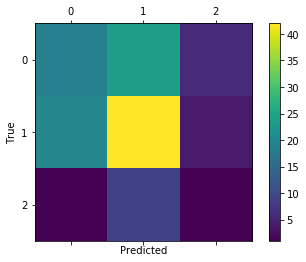

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
print("SVM score:", model.score(X_test, y_test))
conf_matrix(y_test, y_pred)

#Train and Test in LAB

##2 CLASSES: LOW - HIGH STRESS

In [0]:
'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
X = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
y = lab_data['TwoClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)


'''
To see that classes are balanced back
'''
# low = y_train[y_train == "L"]
# print("LOW labeled: ", len(low))
# high = y_train[y_train == "H"]
# print("HIGH labeled: ", len(high))

'\nTo see that classes are balanced back\n'

### Logistic Regression






Logistic Regression score:  0.5


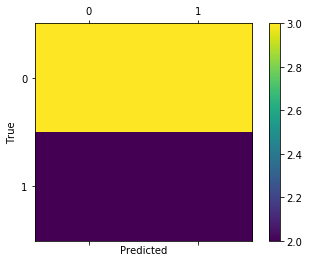

In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Logistic Regression score: ",clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

### Naive Bayes

Naive Bayes score:  0.6


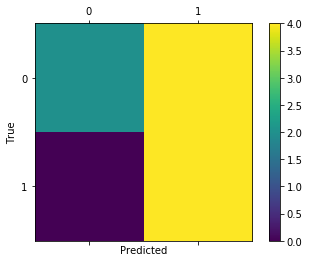

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test)
gnb.score(X_test, y_test)

print("Naive Bayes score: ", gnb.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Decision Tree

Decision Tree score:  0.6


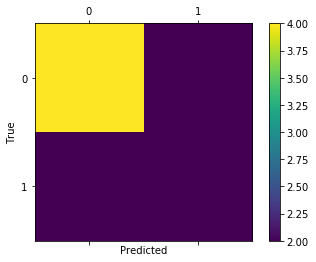

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)

print("Decision Tree score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) score:  0.5


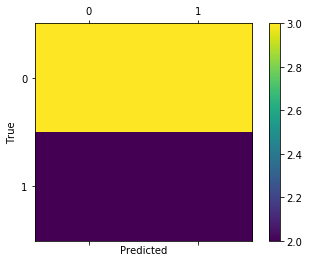

In [0]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Linear Discriminant Analysis (LDA) score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###K-Neigbours Classifier

[1 3 1 3 3 1 1 1 1 3]
K-Neighbours score: 0.4


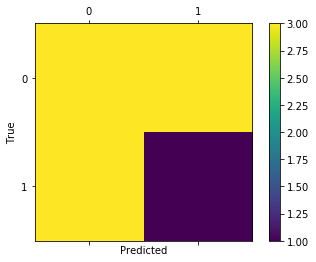

In [0]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(y_pred)
print("K-Neighbours score:", neigh.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###SVM

[3 1 1 3 3 1 3 1 1 3]
SVM score: 0.5


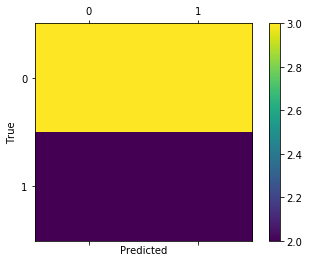

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
print("SVM score:", model.score(X_test, y_test))
conf_matrix(y_test, y_pred)

##3 CLASSES: LOW - MEDIUM - HIGH STRESS

In [0]:
'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
X = lab_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
y = lab_data['ThreeClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

Logistic Regression score:  0.5


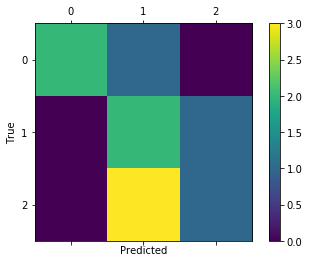

In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Logistic Regression score: ",clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

### Naive Bayes

Naive Bayes score:  0.4


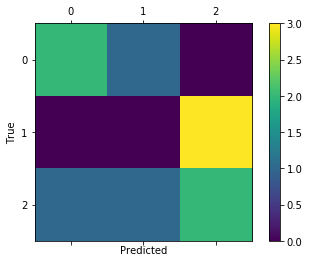

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test)
gnb.score(X_test, y_test)

print("Naive Bayes score: ", gnb.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Decision Tree

Decision Tree score:  0.5


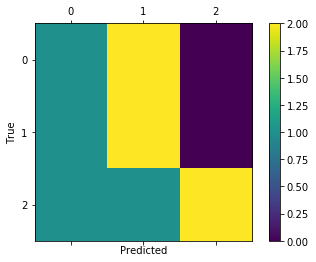

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)

print("Decision Tree score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) score:  0.4


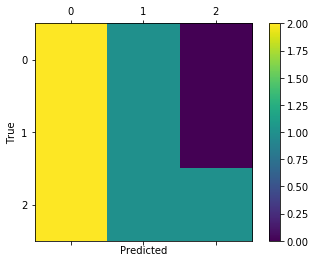

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Linear Discriminant Analysis (LDA) score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###K-Neigbours Classifier

[1 1 1 1 2 3 2 2 3 2]
K-Neighbours score: 0.2


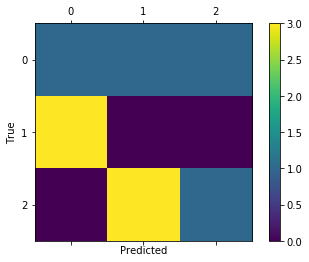

In [0]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(y_pred)
print("K-Neighbours score:", neigh.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###SVM

[2 3 2 2 2 3 2 3 1 2]
SVM score: 0.5


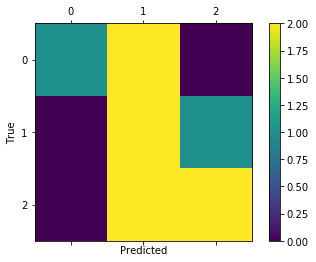

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
print("SVM score:", model.score(X_test, y_test))
conf_matrix(y_test, y_pred)

#Train and Test in DAILY

##2 CLASSES: LOW - HIGH STRESS

In [0]:
'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
X = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
y = daily_data['TwoClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)


'''
To see that classes are balanced back
'''
# low = y_train[y_train == "L"]
# print("LOW labeled: ", len(low))
# high = y_train[y_train == "H"]
# print("HIGH labeled: ", len(high))

'\nTo see that classes are balanced back\n'

### Logistic Regression






Logistic Regression score:  0.6923076923076923


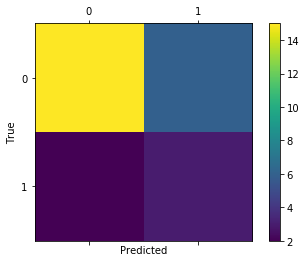

In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Logistic Regression score: ",clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

### Naive Bayes

Naive Bayes score:  0.46153846153846156


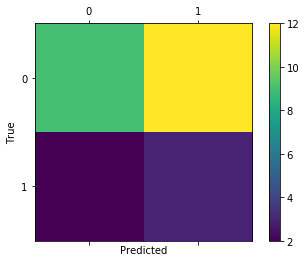

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test)
gnb.score(X_test, y_test)

print("Naive Bayes score: ", gnb.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Decision Tree

Decision Tree score:  0.6538461538461539


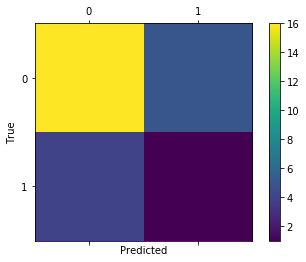

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)

print("Decision Tree score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) score:  0.6153846153846154


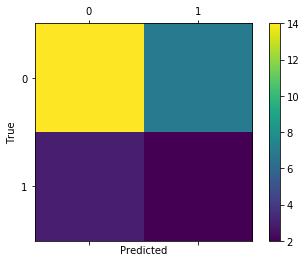

In [0]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Linear Discriminant Analysis (LDA) score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###K-Neigbours Classifier

[1 1 3 1 1 3 1 1 1 1 1 1 1 1 3 1 1 3 1 3 1 1 3 1 1 1]
K-Neighbours score: 0.7307692307692307


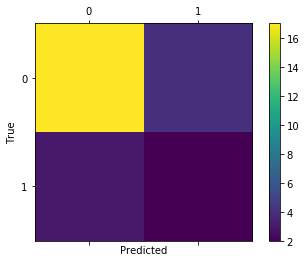

In [0]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(y_pred)
print("K-Neighbours score:", neigh.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###SVM

[3 1 3 3 1 1 1 1 1 1 1 1 3 3 1 3 1 3 1 1 1 1 3 1 1 1]
SVM score: 0.7307692307692307


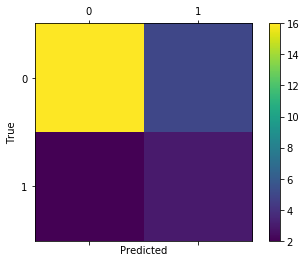

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
print("SVM score:", model.score(X_test, y_test))
conf_matrix(y_test, y_pred)

##3 CLASSES: LOW - MEDIUM - HIGH STRESS

In [0]:
'''
LOAD LAB DATA AND SPLIT INTO TRAIN AND TEST
'''
X = daily_data[['Mean', 'Peak', 'Perc20', 'Perc80', 'QuartDev','Std', 'Strong_Peak', 'dataQual']]
y = daily_data['ThreeClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

'''
Synthetic Minority Over-sampling Technique
'''
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

Logistic Regression score:  0.46153846153846156


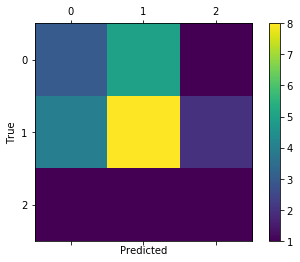

In [0]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=4, multi_class='multinomial', class_weight='balanced', max_iter=4000, penalty="l2").fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Logistic Regression score: ",clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

### Naive Bayes

Naive Bayes score:  0.46153846153846156


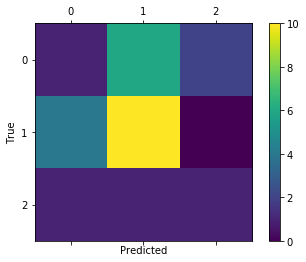

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train, y_train)
y_pred =  gnb.predict(X_test)
gnb.score(X_test, y_test)

print("Naive Bayes score: ", gnb.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Decision Tree

Decision Tree score:  0.5


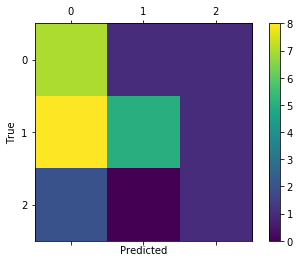

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)

print("Decision Tree score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) score:  0.46153846153846156


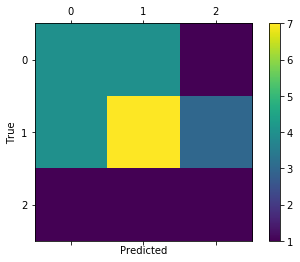

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Linear Discriminant Analysis (LDA) score: ", clf.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###K-Neigbours Classifier

[3 2 1 1 2 2 1 1 2 2 1 2 2 1 3 2 3 2 2 3 1 3 3 1 2 1]
K-Neighbours score: 0.5384615384615384


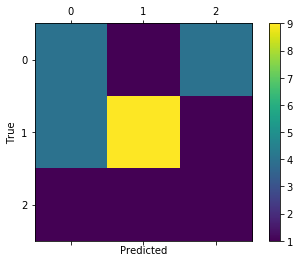

In [0]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(y_pred)
print("K-Neighbours score:", neigh.score(X_test, y_test))
conf_matrix(y_test, y_pred)

###SVM

[3 2 1 2 2 2 1 2 1 2 2 2 3 1 1 2 1 2 1 2 2 1 1 3 2 3]
SVM score: 0.5


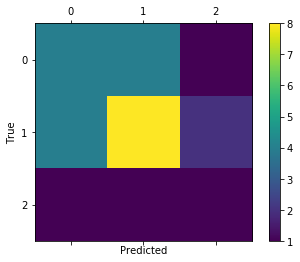

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC(dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
print("SVM score:", model.score(X_test, y_test))
conf_matrix(y_test, y_pred)

#Leave One Person Out (LAB and DAILY Mixed)